In [276]:
import numpy as np
from numpy import exp, abs, log
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import reduce
from operator import mul
def prod(L): return reduce(mul,L)


#I need a function with compact support, and choosing a differentiable seemed nice
#this is the simplest I could think of; it is not otherwise motivated for the
#distributions that I need it for.
def compact_support_function(min=0,max=1,shape=1,skew=1,scale=1):
    """Returns an infinitely differentiable function with compact support
    
    Returns an appropriate transform of exp(1/(x(x-1))).
    Parameters:
      [min,max] : interval on which function is non-zero
      shape     : (>0) larger values make the peak sharper
      skew      : (>0) Values <1 mean skew to left, values >1 mean skew to right
      scale     : maximum value.
    """
    interval_length=max-min
    scale=scale/exp(-4*shape)
    def f(x):
        t=(x-min)/interval_length
        if 0<t<1:
            ts=t**skew
            return scale*exp(shape/ts/(ts-1))
        else:
            return 0
    return f

class simulation:
    def __init__(self,N,beta_dist,q_dist,I0,policy,time_scale=1.0):
        
        #discretize distributions
        beta=[quad(beta_dist,i/N,(i+1)/N)[0] for i in range(N)]
        quarantining_proportion=[quad(q_dist,i/N,(i+1)/N)[0] for i in range(N)]
        q=[]
        quarantined_proportion=[]
        running_total=0
        for i in range(N):
            q.append(quarantining_proportion[i]/(1-running_total))
            running_total+=quarantining_proportion[i]
            quarantined_proportion.append(running_total)
        
        #sanity check that conditional probabilities match total
        assert abs((1-sum(quarantining_proportion)-prod((1-c) for c in q)))< 10e-5
        
        #bookkeeping
        self.beta_dist=beta_dist
        self.q_dist=q_dist
        self.beta=beta
        self.quarantining_proportion=quarantining_proportion
        self.quarantined_proportion=quarantined_proportion
        self.q=q
        self._s=[]
        self._r=[]
        self._I=[]
        self._Q=[]
        self._betaprime=[]
        self.I0=I0
        self.N=N
        self.policy=policy
        self._policy=[]
        self.time_scale=time_scale
        
    #access functions: our initial conditions are, for T<0, a proportion I0 of the
    #population uniformly distributed over the I_a, with no quarantining or infections happening.
    def s(self,T):
        return self._s[T] if T>=0 else 1-self.I0
    def r(self,T):
        return self._r[T] if T>=0 else 0
    def I(self,T):
        return self._I[T] if T>=0 else tuple(self.I0/self.N for i in range(self.N))
    def Q(self,T):
        return self._Q[T] if T>=0 else tuple(0 for i in range(self.N))
    def betaprime(self,T):
        return self._betaprime[T] if T>=0 else tuple(0 for i in range(self.N))
    
    #this is the actual step. It computes step T+1 from step T. It's an internal routine.
    def step_after(self,T):
        N=self.N
        
        #we should only get called if T+1 is really the next step to be computed.
        if len(self._s) != T+1:
            raise RuntimeError("length mismatch")
        policyT=self.policy(self,T/N)
        self._policy.append(policyT)
        C_contact,C_test,C_trace=policyT
        Ctst=C_test/N
        Ctrc=C_trace**(1/N)
        s=self.s(T)
        r=self.r(T)
        betaprime=[s*self.beta[i]*C_contact for i in range(self.N)]
        IT=self.I(T)
        QT=self.Q(T)
        Inew=sum([d*i for d,i in zip(betaprime,IT)])
        Qnew=[(c+Ctst)*i for c,i in zip(self.q,IT)]
        
        #this is the loop where we compute the quarantining contribution
        #of contact tracing: we work from the oldest infections forward,
        #so that we can take into account the derived infections from
        #the ones added earlier in the loop.
        for dT in range(self.N-1,-1,-1):
            for age in range(dT,self.N):
                inc=self.betaprime(T-dT)[age-dT]*Qnew[age]
                Qnew[age-dT]+=C_trace*inc
        IT=[i-q for i,q in zip(IT,Qnew)]
        QT=[v+q for v,q in zip(QT,Qnew)]
        s-=Inew
        r+=IT[-1]+QT[-1]
        self._s.append(s)
        self._r.append(r)
        self._I.append([Inew]+IT[:-1])
        self._Q.append([0]+QT[:-1])
        self._betaprime.append(betaprime)
        
    def compute(self,t):
        """Ensures that the simulation is computed to time t (i.e., t*N steps)
        """
        Tend=int(np.floor(t/self.time_scale*self.N))
        for T in range(len(self._s)-1,Tend):
            self.step_after(T)

    def disease_plots(self):
        """produces plots illustrating the characteristics of the configured disease
        """
        N=self.N
        xr=np.arange(0,1,0.01)
        x_times=[x*self.time_scale for x in xr]
        fig, ((ax1,ax4),(ax2,ax3)) = plt.subplots(2,2)
        ax4.get_shared_y_axes().join(ax1, ax4)
        fig.set_size_inches(16,10)
        fvals=[self.beta_dist(a) for a in xr]
        infection_coefficient=[quad(self.beta_dist,i/N,(i+1)/N)[0] for i in range(N)]
        R0=sum(infection_coefficient)
        ticks=np.arange(0+0.5*self.time_scale/N,self.time_scale,self.time_scale/N)
        ax1.bar(ticks,[i*N for i in self.beta],alpha=0.5,width=self.time_scale/N,label="infectivity integrated\n over intervals")
        ax1.plot(x_times,fvals,color="black",label="infectivity density")
        ax1.set_title("Infectivity (area=R0)")
        ax1.set_xlabel("infection age")
        ax1.set_ylabel("infection rate")
        ax1.text(0.2,0.5,"R0 = {:3.3}".format(R0))
        ax1.legend(loc="upper right")

        fvals=[self.q_dist(a) for a in xr]
        ax2.plot(x_times,fvals,color="black",label="density")
        ax2.bar(ticks,[i*N for i in self.quarantining_proportion],alpha=0.5,width=self.time_scale/N,label="integrated")
        ax2.bar(ticks,[i*N for i in self.q],alpha=0.2,color="red",width=self.time_scale/N,label="conditional rates")
        ax2.set_title("Symptom distribution")
        ax2.text(0.1,0.2,"eventual symptomatic proportion = {:3.3}".format(sum(self.quarantining_proportion)))
        ax2.legend()
        ax2.set_xlabel("infection age")
        ax2.set_ylabel("symptom rate")

        ax3.set_title("asymptomatic infected proportion")
        ax3.set_xlabel("infection age")
        ax3.set_ylabel("asymptomatic proportion")
        ax3.bar(ticks,[1-p for p in self.quarantined_proportion],alpha=0.5,width=self.time_scale/N)

        q_adjusted_infection_coefficient=[(1-p)*c for p,c in zip(self.quarantined_proportion,self.beta)]
        R0q=sum(q_adjusted_infection_coefficient)
        ax4.set_title("Quarantine-adjusted infectivity (area=R0q)")
        ax4.set_xlabel("infection age")
        ax4.set_ylabel("infection rate")
        ax4.bar(ticks,[N*c for c in q_adjusted_infection_coefficient],alpha=0.5,width=self.time_scale/N)
        ax4.text(0.2,0.5,"R0q = {:3.3}".format(R0q))
        return fig
        
    def time_plots(self,t):
        """Produces time series plots that show the simulation for time (0...t)
        """
        self.compute(t)
        T=int(t*self.N/self.time_scale)
        s=self._s[:T]
        r=self._r[:T]
        I=self._I[:T]
        Q=self._Q[:T]
        fig, (ax2,ax1,ax3) = plt.subplots(1,3)
        fig.set_size_inches(16,5)
        times=[a/self.N*self.time_scale for a in range(T)]
        ax1.set_title("active cases")
        ax1.set_xlabel("time")
        ax1.set_ylabel("proportion of population")
        ax1.plot(times,[sum(i) for i in I],label="infected unquarantined")
        ax1.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax1.plot(times,[sum(i) for i in Q],label="quarantined")
        ax1.legend(loc="upper right")
        ax2.set_title("susceptible/removed")
        ax2.set_xlabel("time")
        ax2.set_ylabel("proportion of population")
        ax2.plot(times,s,label="susceptible")
        ax2.plot(times,[sum(i)+sum(q) for i,q in zip(I,Q)],label="total active")
        ax2.plot(times,r,label="removed")
        ax2.legend()
        ax2.set_ylim([0,1])
        ax3.set_title("policy")
        ax3.set_ylim([0,1])
        ax3.set_xlabel("time")
        ax3.set_ylabel("measure intensity")
        policy=self._policy[:T]
        ax3.plot(times,[1-a[0] for a in policy],label="physical distancing")
        ax3.plot(times,[a[1] for a in policy], label="surveilance testing")
        ax3.plot(times,[a[2] for a in policy],label="contact tracing")
        ax3.legend()
        return fig

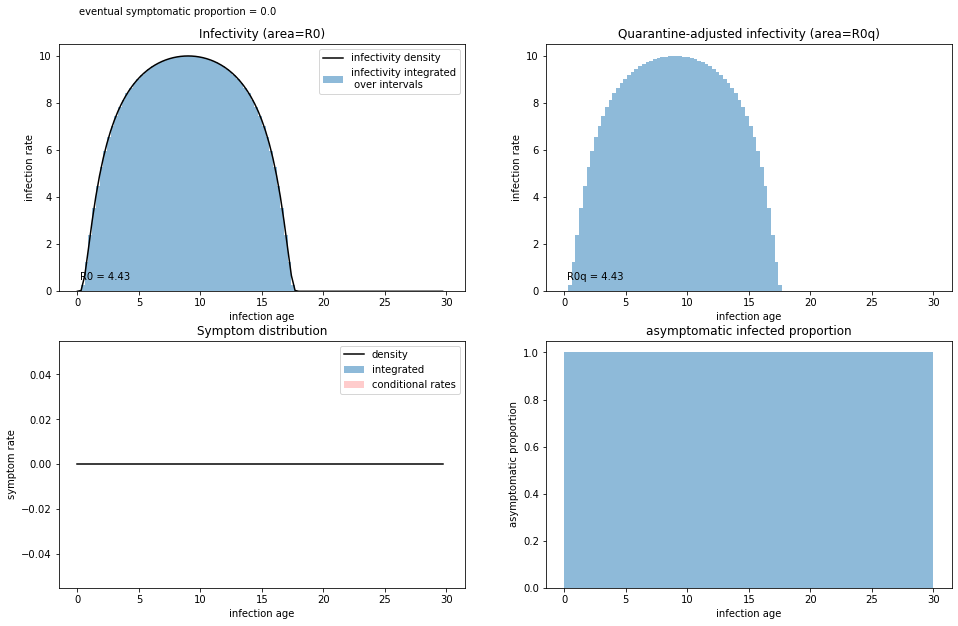

In [300]:
beta_dist=compact_support_function(0,0.6,scale=10,shape=0.1,skew=1)
q_dist=compact_support_function(0.02,0.7,scale=0,skew=1,shape=1)

def policy(sim,t):
    C_contact=1
    C_test=0
    C_trace=0
    return (C_contact,C_test,C_trace)    
        
S=simulation(100,beta_dist,q_dist,0.001,policy=policy,time_scale=30)
_=S.disease_plots()

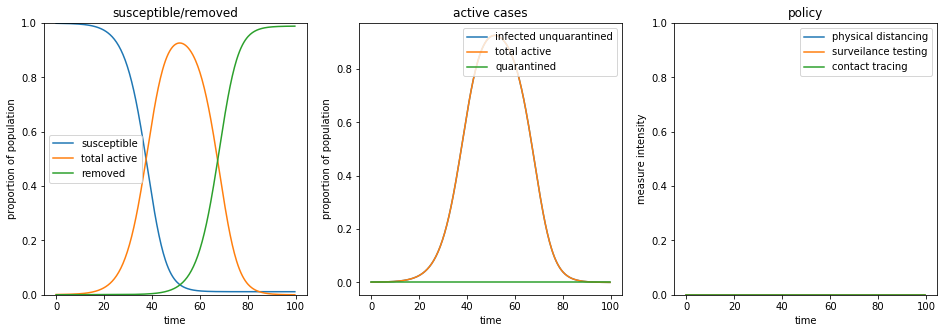

In [301]:
_=S.time_plots(100)

In [302]:
Z=[sum(q)+sum(i) for q,i in zip(S._Q,S._I)]

In [303]:
min([log(2)/log(Z[i+1]/Z[i])*S.time_scale/S.N for i in range(10,100)])

3.5839470135411684

In [274]:
17*S.time_scale/S.N

5.1

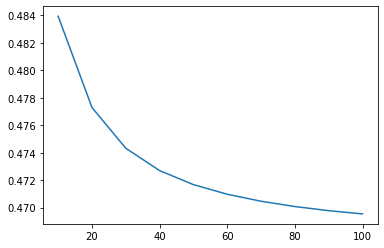

In [209]:
Nvals=[10,20,30,40,50,60,70,80,90,100]
rinf=[]
qmax=[]
for N in Nvals:
    S=simulation(N,beta_dist,q_dist,0.001,policy=policy,time_scale=30)
    S.compute(400)
    qmax.append(max(sum(qq)+sum(ii) for qq,ii in zip(S._Q,S._I)))
    rinf.append(S._r[-1])
plt.plot(Nvals,qmax)

In [216]:
crange=np.arange(0,1,0.1)
rinf=[]
qmax=[]
for c in crange:
    def policy(sim,t):
        C_contact=1
        C_test=0
        C_trace=c
        return (C_contact,C_test,C_trace)    
        
    S=simulation(70,beta_dist,q_dist,0.001,policy=policy,time_scale=30)
    S.compute(400)
    qmax.append(max(sum(qq)+sum(ii) for qq,ii in zip(S._Q,S._I)))
    rinf.append(S._r[-1])
    

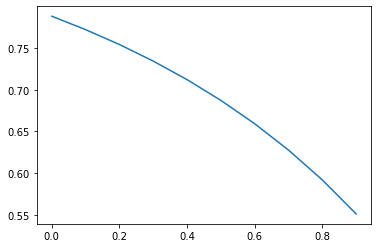

In [217]:
plt.plot(list(crange),rinf)

Test scenarios
==============

Below we illustrate a disease with $R_0=3.05$ and an symptom distribution that causes symptoms in about half the patients (eventually). We assume symptomatic patients are quarantined upon symptom onset, we get a quarantine-adjusted infectivity of $R_{0,q}=1.96$. If we run the simulation without interventions, we find that eventually about 80% gets infected, and maximum resource use (measured by maximum quarantined) is 9%

Note that our disease duration is 1, so when we simulate to $t=40$, then for a disease with a typical duration of $14$ days, this amounts to about 19 months.

r_infty = 0.798, Q_max= 0.167


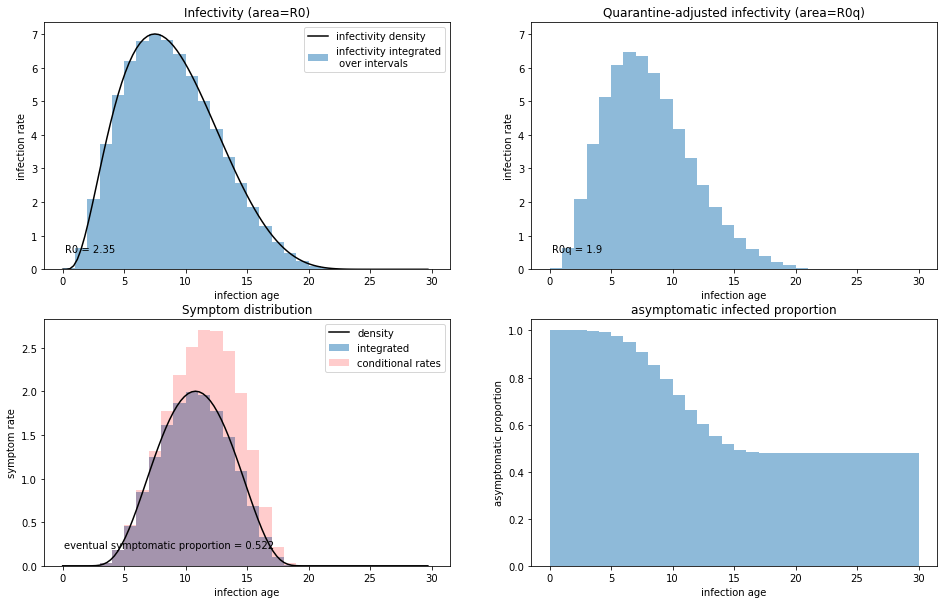

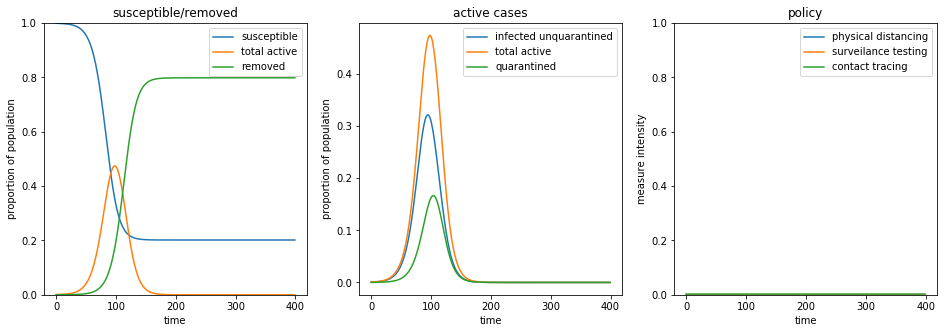

In [208]:
_=S.disease_plots()
_=S.time_plots(400)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))

For comparison, we compute a completely unmitigated epidemic, where even symptomatic individuals are not quarantined. For dynamical purposes, this means we can simply set $\delta_q(\alpha)=0$. In the rest of the scenarios, we assume that symptomatic individuals are quarantined immediately.

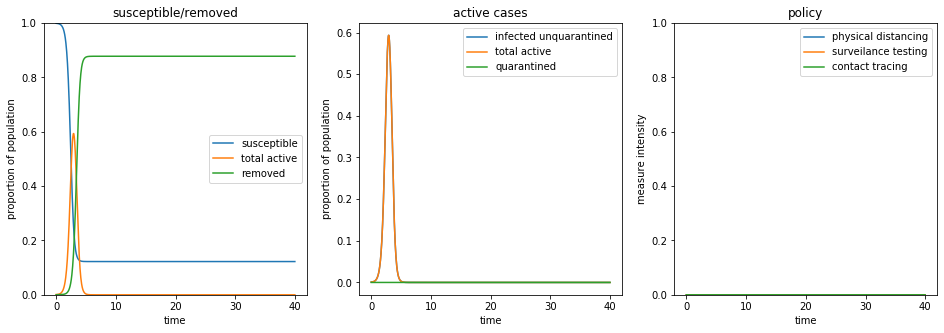

In [177]:
S=simulation(30,beta_dist,lambda alpha:0,0.001,policy=policy)
_=S.time_plots(40)

In the next scenario, we use pulsed physical distancing: whenever the quarantined population (these are the active cases we're aware of, and that use resources) exceeds $0.5\%$, we halve the contact rate. We see that resource use overshoots significantly (we get to 0.93%) and we land at a softer $r_\infty=0.58$, indicating that in the unmitigated epidemic we overshot herd immunity. Note that the herd immunity here is *with* perfect quarantining of symptomatic individuals.

r_infty = 0.582, Q_max= 0.00932


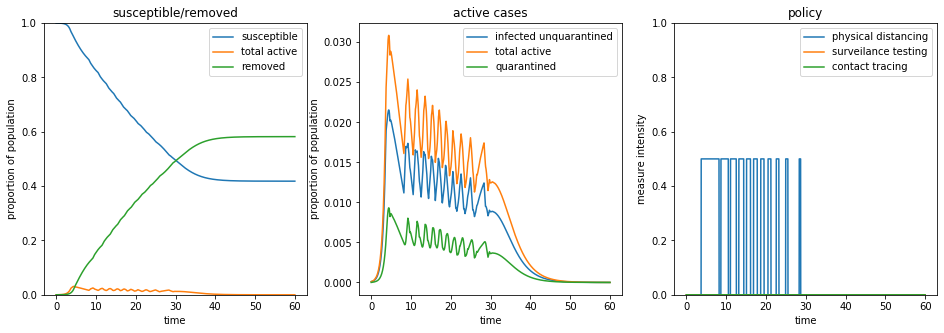

In [315]:
def policy(sim,t):
    C_contact=1
    C_test=0
    C_trace=0
    N=sim.N; T=int(N*t)
    if sum(sim.Q(T)) > 0.005:
        C_contact=0.5
    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.0001,policy=policy)
_=S.time_plots(60)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))

We add testing: every time unit, we test 40% of the population. The effect is disappointing: yes, we lower to $r_\infty=47.7%$ and we soften our resource use, but testing 40% of the population every 2 weeks would be infeasible. Note that *quarantined* as a resource use measure is now contaminated: due to testing, there are now also asymptomatic persons in  quarantine.

r_infty = 0.476, Q_max= 0.00726


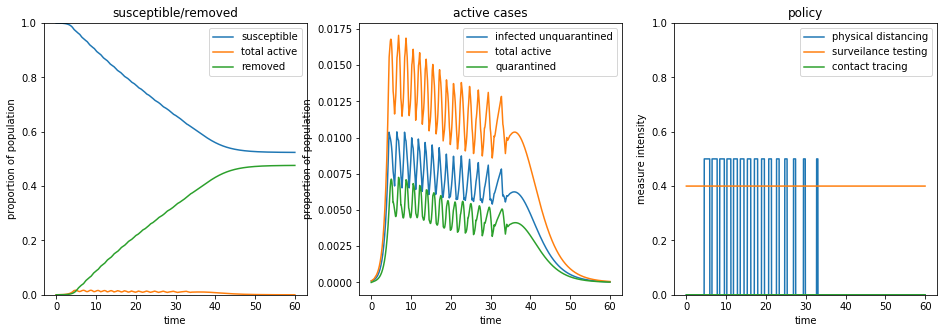

In [312]:
def policy(sim,t):
    C_contact=1
    C_test=0.4
    C_trace=0
    N=sim.N; T=int(N*t)
    if sum(sim.Q(T)) > 0.005:
        C_contact=0.5
    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.0001,policy=policy)
_=S.time_plots(60)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))

We introduce contact tracing. As an illustration, we set $C_\text{trace}=0.5$ and reduce the testing rate to $C_\text{test}=0.3$. We see a dramatic drop in herd immunity level: $r_\infty=15\%$. We see that the pulsed physical distancing doesn't get activated.

r_infty = 0.149, Q_max= 0.00288


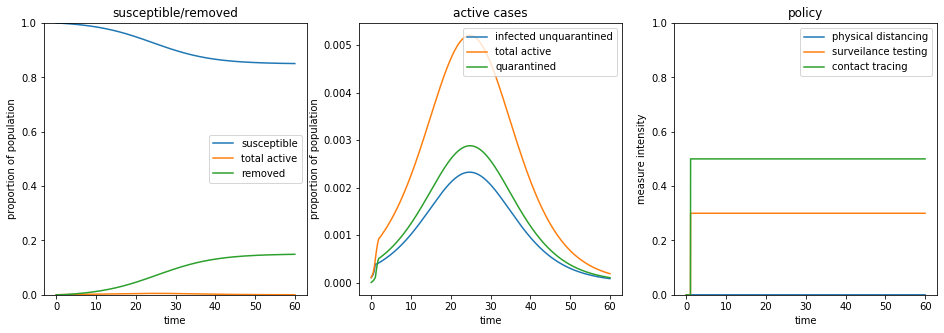

In [313]:
def policy(sim,t):
    C_contact=1
    C_test=0
    C_trace=0
    N=sim.N; T=int(N*t)
    if sum(sim.Q(T)) > 0.005:
        C_contact=0.5
    if t>1:
        C_test=0.30
        C_trace=0.5

    return (C_contact,C_test,C_trace)    
        
S=simulation(30,beta_dist,q_dist,0.0001,policy=policy)
_=S.time_plots(60)
print("r_infty = {:3.3}, Q_max= {:3.3}".format(max(S._r),max( map(sum,S._Q))))